# Download a dataset of face images

In [1]:
import scipy.io as io
import urllib.request

urllib.request.urlretrieve('http://www.cad.zju.edu.cn/home/dengcai/Data/YaleB/YaleB_32x32.mat','YaleFaces.mat')
M = io.loadmat('YaleFaces.mat')
data = M['fea']
labels = M['gnd'].flatten()
print(data.shape)
print(labels)

(2414, 1024)
[ 1  1  1 ... 38 38 38]


We see there are 2414 images, each with 1024 pixels (32x32). The labels indicate which person is shown in each image. There are 38 different people in the dataset, and each has many different pictures of their face under different lighting conditions and taken from slightly different angles, etc. 


# First we need to install graphlearning.

In [2]:
pip install graphlearning -q

Note: you may need to restart the kernel to use updated packages.


# Display some face images using the graph learning image_grid function.

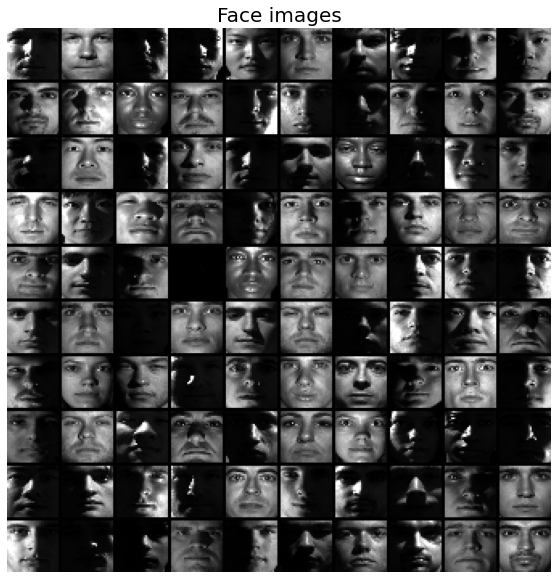

In [3]:
import graphlearning as gl
import numpy as np

gl.utils.image_grid(data[np.random.permutation(data.shape[0]),:],n_rows=10,n_cols=10,title='Face images',fontsize=20)

The goal of face recognition is to detect whether a new image of a face matches one from an existing dataset, and retrieve that matching image. To do this, we will split the face images into training and testing, treating the testing images as new images we want to match to images in the training set. Use sklearn.model_selection.train_test_split to split the images into 30% testing and 70% training data.

# Split the face images into training(70%) and testing(30%) data

In [4]:
from sklearn.model_selection import train_test_split

data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=1)

# Perform PCA on the training images

Perform PCA on the training images to find an affine subspace that well-aproximates the face dataset. The principal components are called "eigenfaces". The number of principal components can be changed, but 100 works well.

In [5]:
from scipy.sparse import linalg

num_comps=100
m = data_train.shape[1] #Number of pixels per image
k = len(np.unique(labels_train)) #Number of classes

#Arrays to store all principal components, and means for each class
Means = np.zeros(m)
V = np.zeros((m,num_comps))

#Loop over all faces
print("Training: Computing PCA with %d components on training data...Finished"%num_comps)
X = data_train

#Mean image and centered data
X_mean = np.mean(X,axis=0) 
Y = X - X_mean #Y is the centered data

#Main eigenvector/eigenvalue computation
E, V = linalg.eigsh(Y.T@Y,k=num_comps,which='LM') #Principal components

Training: Computing PCA with 100 components on training data...Finished


# Display some of the eigenfaces

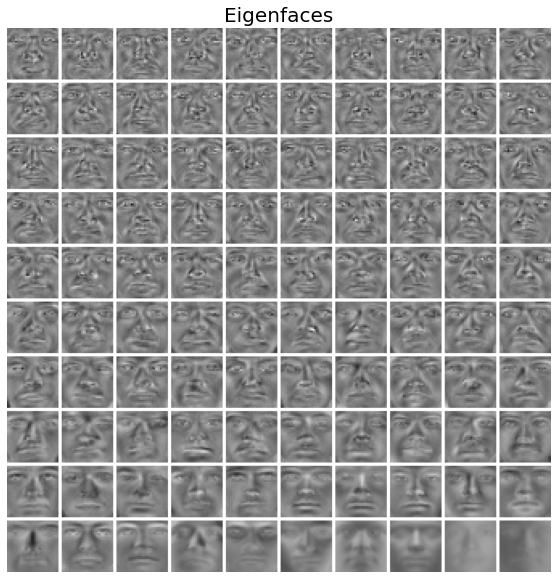

In [6]:
gl.utils.image_grid(V.T,n_rows=10,n_cols=10,title='Eigenfaces',normalize=True,fontsize=20)

# Using Euclidean distance to classifying testing data with accuracy ~66%

Project the training set and testing sets onto the PCA affine subspace. Then match the testing image to training images by finding the image that is closest in the projected lower dimensional space with Euclidean distance.

In [7]:
#Loop over faces and compute distances from testing images to each face's PCA subspace
print("Classifying testing data by Euclidean distance to the training data")
labels_pred=np.zeros(len(data_test))
train_pca=(data_train-X_mean)@V
test_pca=(data_test-X_mean)@V
for i in range(len(data_test)):
  labels_pred[i]=labels_train[np.argmin(np.linalg.norm(train_pca-test_pca[i,:],axis=1))]
  #labels_pred[i]=labels_train[np.argmin(np.sum((train_pca-test_pca[i,:])**2,axis=1))]

#Compute accuracy and print to sreen
accuracy = np.sum(labels_pred == labels_test)/len(data_test)
print('\nClassification accuracy = %.1f%%'%(100*accuracy))


Classifying testing data by Euclidean distance to the training data

Classification accuracy = 66.2%


# Using Mahalanobis distance to classifying testing data with accuracy ~90%

Project the training set and testing sets onto the PCA affine subspace. Then match the testing image to training images by finding the image that is closest in the projected lower dimensional space with Mahalanobbis distance.

In [8]:
#Loop over faces and compute distances from testing images to each face's PCA subspace
print("Classifying testing data by Mahalanobis distance to the training data")
labels_maha_pred=np.zeros(len(data_test))
train_pca=(data_train-X_mean)@V
test_pca=(data_test-X_mean)@V
for i in range(len(data_test)):
  labels_maha_pred[i]=labels_train[np.argmin((train_pca-test_pca[i,:])**2@(1/E))]

#Compute accuracy and print to sreen
accuracy = np.sum(labels_maha_pred == labels_test)/len(data_test)
print('\nClassification accuracy = %.1f%%'%(100*accuracy))


Classifying testing data by Mahalanobis distance to the training data

Classification accuracy = 89.0%
